In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#
from sklearn.model_selection import train_test_split
# Поиск по сетке оптимальных гиперпараметров модели обучения,
# с применением алгоритма кросс-валидации
from sklearn.model_selection import GridSearchCV
# Методы для масштабирования признаков
from sklearn.preprocessing import StandardScaler #, MinMaxScaler
# Модель K-ближайших соседей - классификация
from sklearn.neighbors import KNeighborsClassifier
# Метрика (оценка) для задач классификации: accuracy, precision и recall
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Матрица ошибок и метод для вычисления ошибок 1-го и 2-го рода
from sklearn.metrics import confusion_matrix, classification_report
# Инструменты для визуализации матрицы ошибок
from sklearn.metrics import ConfusionMatrixDisplay
# Инструменты для визуализации Precision, Recall и ROC-графика
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

%matplotlib inline

In [2]:
print(f'numpy: {np.__version__}, pandas: {pd.__version__}, matplotlib: {matplotlib.__version__}, seaborn: {sns.__version__}, sklearn: {sklearn.__version__}')

numpy: 1.24.3, pandas: 2.0.3, matplotlib: 3.7.2, seaborn: 0.12.2, sklearn: 1.3.0


In [3]:
def targetToInt(target):
    if target == 'M':
        return 1
    else:
        return 0

In [4]:
# Загрузить данные в DataFrame из csv-файла
df = pd.read_csv('data.csv')
df.sample(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
94,862028,M,15.06,19.83,100.30,705.6,0.10390,0.15530,0.17000,0.08815,...,24.23,123.50,1025.0,0.15510,0.4203,0.5203,0.21150,0.2834,0.08234,NaN
354,901011,B,11.14,14.07,71.24,384.6,0.07274,0.06064,0.04505,0.01471,...,15.82,79.62,453.5,0.08864,0.1256,0.1201,0.03922,0.2576,0.07018,NaN
335,89742801,M,17.06,21.00,111.80,918.6,0.11190,0.10560,0.15080,0.09934,...,33.15,143.20,1362.0,0.14490,0.2053,0.3920,0.18270,0.2623,0.07599,NaN


In [5]:
# Удилить колонки 'id' и 'Unnamed: 32'
df = df.drop(labels=['id', 'Unnamed: 32'], axis='columns')
#df.info()

In [6]:
# Перевести целевую переменную в метки класса 0 и 1
df['diagnosis'] = df['diagnosis'].apply(targetToInt)
df['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [7]:
targetName = 'diagnosis'
# Признаки - Features
#X = df.drop(targetName, axis='columns')
# Отобрали только наиболее значимые признаки (иначе НЕ работает)
X = df[[
    'concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst',
    'radius_mean', 'area_mean', 'concavity_worst', 'concavity_mean', 'compactness_worst', 'compactness_mean',
    'perimeter_se', 'area_se', 'radius_se'
]]
# Целевая переменная
y = df[targetName]

In [8]:
# Разбить набор данных на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Создать объект для масштабирования признаков
standardScaler = StandardScaler()

# На основе анализа ТОЛЬКО тренировочных признаков,
# подготовить объект к масштабированию признаков
standardScaler.fit(X_train)  # ВАЖНО! В этот метод передаем только тренировочный набор признаков

# Масштабирование тренировочных признаков
# mean = 0; std = 1
X_scaled_train = standardScaler.transform(X_train)
print(X_scaled_train.mean(), X_scaled_train.std(), end='\n\n')

# Масштабирование тестовых признаков
# mean = 0; std = 1
X_scaled_test = standardScaler.transform(X_test)
print(X_scaled_train.shape, X_scaled_test.shape)

3.496179709037344e-18 1.0

(398, 15) (171, 15)


In [9]:
# Создать объект модели обучения
knnModel = KNeighborsClassifier()

# Обучить модель
knnModel.fit(X_scaled_train, y_train)

# Вычислить целевые переменные, на основе обученной модели
yPredict = knnModel.predict(X_scaled_test)
#yPredict

In [10]:
# Оценки (метрики)

# Accuracy - Процент правильных ответов
accuracy = accuracy_score(y_test, yPredict)
print(f'Accuracy: {accuracy:0.3f}', end='\n\n')

# Precision - Доля объектов, названных классификатором положительными
#     и при этом действительно являющимися положительными
precision = precision_score(y_test, yPredict)
print(f'Precision: {precision:0.3f}', end='\n\n')

# Recall - Доля объектов положительного класса из всех объектов
#     положительного класса, которую  нашел алгоритм
recall = recall_score(y_test, yPredict)
print(f'Recall: {recall:0.3f}')

Accuracy: 0.912

Precision: 0.870

Recall: 0.909


In [11]:
# Вычислить матрицу ошибок
# По главной диагонали: правильные ответы.
# По второй диагонали: ошибки
# confusionMatrix[0][1]: Модель выдала True, там где на самом деле было Fale
# confusionMatrix[1][0]: Модель выдала False, там где на самом деле было True
confusionMatrix = confusion_matrix(y_test, yPredict)
confusionMatrix

array([[96,  9],
       [ 6, 60]], dtype=int64)

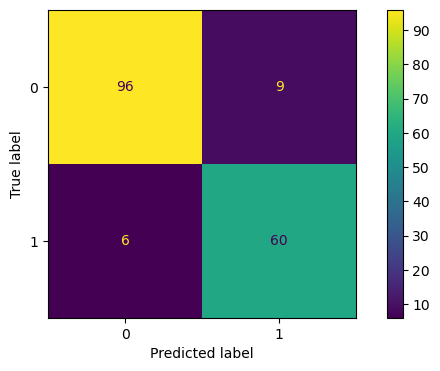

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), dpi=100)
# Визуализация матрицы ошибок (на графике)
ConfusionMatrixDisplay.from_estimator(estimator=knnModel, X=X_scaled_test, y=y_test, ax=axes);

In [13]:
# Матрица с метриками (по отдельным классам): Precision, Recall и F1-score
# F1-score - Гармоническое среднее между Precision и Recall
# support - Количество значений отдельных классов, в тестовом наборе данных
# macro avg - Обычное среднее
# weighted avg - Взвешенное среднее, с учетом количества значений отдельных классов
classificationReport = classification_report(y_test, yPredict)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       105
           1       0.87      0.91      0.89        66

    accuracy                           0.91       171
   macro avg       0.91      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171



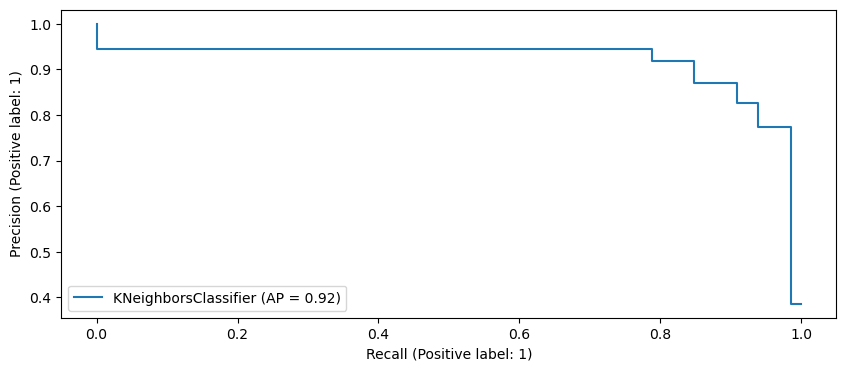

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
# Визуализация Precision и Recall
PrecisionRecallDisplay.from_estimator(estimator=knnModel, X=X_scaled_test, y=y_test, ax=axes);

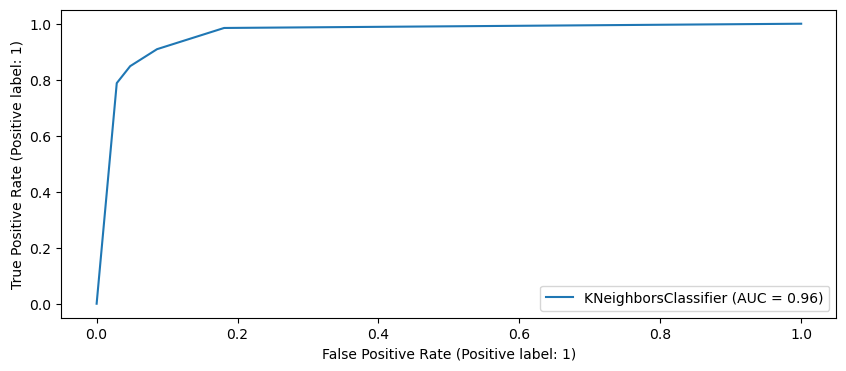

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
# ROC-график
RocCurveDisplay.from_estimator(estimator=knnModel, X=X_scaled_test, y=y_test, ax=axes);

In [16]:
# Поиск по сетке оптимальных гиперпараметров

In [17]:
# Создать объект модели обучения
knnModel = KNeighborsClassifier(n_neighbors=1)

# Значения гиперпараметров модели обучения, которые будут проверяться как оптимальные
paramsGrid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}

# Поиск по сетке
gridSearchCV = GridSearchCV(estimator=knnModel, param_grid=paramsGrid, cv=5, verbose=1)

In [18]:
# Найти оптимальную комбинацию гиперпараметров (с помощью метода кросс-валидации)
# и вернуть на выходе обученную модель
gridSearchCV.fit(X_scaled_train, y_train)

# Какая комбинация гиперпараметров лучшая
bestParams = gridSearchCV.best_params_
bestParams

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'n_neighbors': 7}

In [19]:
# Вычислить целевые переменные, на основе обученной модели
yPredict = gridSearchCV.predict(X_scaled_test)
#yPredict

In [20]:
# Оценки (метрики)

# Accuracy - Процент правильных ответов
accuracy = accuracy_score(y_test, yPredict)
print(f'Accuracy: {accuracy:0.3f}', end='\n\n')

# Precision - Доля объектов, названных классификатором положительными
#     и при этом действительно являющимися положительными
precision = precision_score(y_test, yPredict)
print(f'Precision: {precision:0.3f}', end='\n\n')

# Recall - Доля объектов положительного класса из всех объектов
#     положительного класса, которую  нашел алгоритм
recall = recall_score(y_test, yPredict)
print(f'Recall: {recall:0.3f}')

Accuracy: 0.924

Precision: 0.896

Recall: 0.909


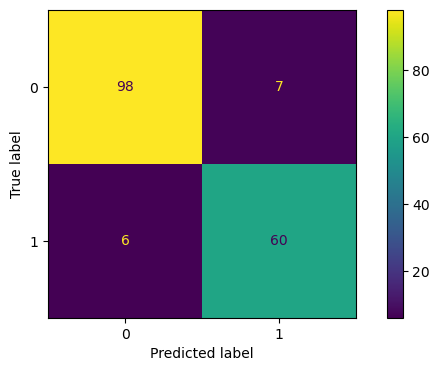

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), dpi=100)
# Визуализация матрицы ошибок (на графике)
ConfusionMatrixDisplay.from_estimator(estimator=gridSearchCV, X=X_scaled_test, y=y_test, ax=axes);

In [22]:
# Без подбора гиперпараметров (при числе соседей 5), метрики были: Accuracy: 0.912, Precision: 0.870, Recall: 0.909

# После поиска по сетке оптимального количества ближайщих соседей,
# метрики стали: Accuracy: 0.924, Precision: 0.896, Recall: 0.909

# По метрикам вывод делать сложно (они практически не изменились). Но на матрице ошибок видно,
# что при оптимальном числе соседей - 7, модель сделала на 2 ошибки меньше.